# 2.4 クラス分類器の不確実性推定
クラス分類器の予測に対する不確実性推定機能
- scikit-learnインターフェースの有用な機能の1つ
- あるテストポイントに対してクラス分類器が出力する予測クラスだけでなく、その予測がどのくらい確かなのかを確認する機能

1. 決定関数：decision_function
2. 確立の予測：predict_proba

In [3]:
import mglearn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
# vscode で jupyter notebookを使用したとき図の背景色をデフォルトの白にする。
import matplotlib as mpl
%matplotlib inline
mpl.style.use('default')

In [8]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.datasets import make_circles
X, y = make_circles(noise=0.25, factor=0.5, random_state=1)

# わかりやすいようにクラスをblueとredにする。
y_named = np.array(['blue', 'red'])[y]

# train_test_splitは任意の数の配列に適用できる。
# すべての配列は整合するように分割される。
X_train, X_test, y_train_named, y_test_named ,y_train, y_test = train_test_split(
    X,y_named, y, random_state=0
)
# 勾配ブースティングの構築
gbrt = GradientBoostingClassifier(random_state=0)
gbrt.fit(X_train, y_train_named)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              n_iter_no_change=None, presort='auto', random_state=0,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

## 2.4.1 決定関数(Decition Function)

In [13]:
print('X_test.shape:{}'.format(X_test.shape))
# モデルが信じている度合いが格納されており、正であれば「陽性」,負であれば「陰性」を意味する。
print('Decision function shape:{}'.format(gbrt.decision_function(X_test).shape))

# decition-functionの最初のいくつかを表示
# 決定関数の符号だけ見れば、予測クラスがわかる。
print('Decision function:{}'.format(gbrt.decision_function(X_test)[:6]))

# 決定関数の値に閾値を適用して真偽に分類したもの
print('Thresholded dection function:\n{}'.format(
    gbrt.decision_function(X_test) > 0))
# 予測結果
print('Predicitons:\n{}'.format(gbrt.predict(X_test)))

# True/Falseを0/1に
greater_zero = (gbrt.decision_function(X_test) > 0).astype(int)
# 0/1をclasses_のインデックスに使う。(classes_属性を使うと完全にpredictと同じ結果を再現できる)
pred = gbrt.classes_[greater_zero]
# predはgbrt.predictの出力と同じになる。
print('Pred is equal to predictions: {}'.format(
    np.all(pred == gbrt.predict(X_test))))

# 決定関数のレンジは決まってなく、データとモデルパラメータに依存する。
# 従って、解釈が難しい
decision_function = gbrt.decision_function(X_test)
print('Decision function minimum:{:.2f} maximum:{:.2f}'.format(
    np.min(decision_function), np.max(decision_function)))

X_test.shape:(25, 2)
Decision function shape:(25,)
Decision function:[ 4.13592629 -1.7016989  -3.95106099 -3.62599351  4.28986668  3.66166106]
Thresholded dection function:
[ True False False False  True  True False  True  True  True False  True
  True False  True False False False  True  True  True  True  True False
 False]
Predicitons:
['red' 'blue' 'blue' 'blue' 'red' 'red' 'blue' 'red' 'red' 'red' 'blue'
 'red' 'red' 'blue' 'red' 'blue' 'blue' 'blue' 'red' 'red' 'red' 'red'
 'red' 'blue' 'blue']
Pred is equal to predictions: True
Decision function minimum:-7.69 maximum:4.29


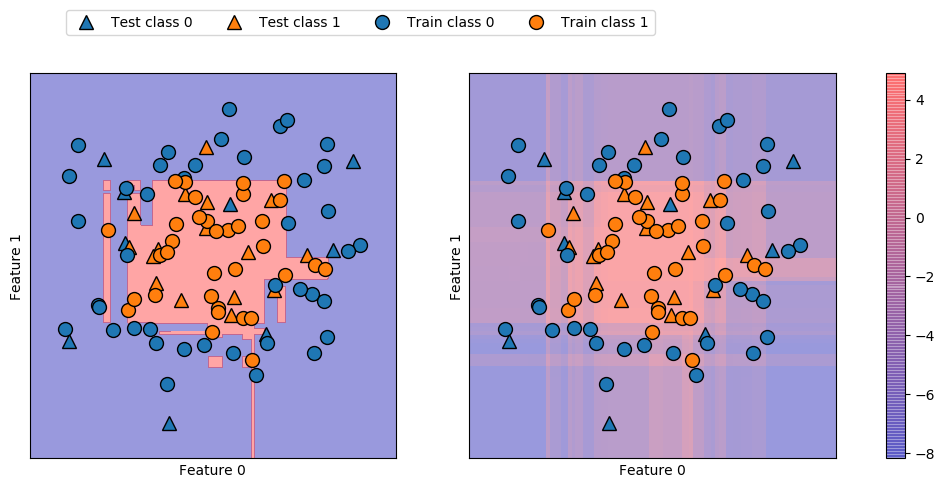

In [18]:
# 決定境界(左)と決定関数(右)の可視化
# 決定関数を可視化することで確信度の可視化ができる。
fig, axes = plt.subplots(1,2,figsize=(13,5))
mglearn.tools.plot_2d_separator(gbrt, X, ax=axes[0], alpha=.4, fill=True, cm=mglearn.cm2)
score_image = mglearn.tools.plot_2d_scores(gbrt, X, ax=axes[1], alpha=.4, cm=mglearn.ReBl)

for ax in axes:
    # 訓練データポイントとテストデータポイントをプロット
    mglearn.discrete_scatter(X_test[:, 0], X_test[:, 1], y_test, markers='^', ax=ax)
    mglearn.discrete_scatter(X_train[:, 0], X_train[:, 1], y_train, markers='o', ax=ax)
    ax.set_xlabel('Feature 0')
    ax.set_ylabel('Feature 1')
cbar = plt.colorbar(score_image, ax=axes.tolist())
axes[0].legend(['Test class 0','Test class 1','Train class 0','Train class 1'], ncol=4, loc=(.1,1.1))

## 2.4.2 確率の予測

In [20]:
# 確率配列の形
# 第1エントリは第1クラスの予測確率で第2エントリは第2クラスの予測確率
print('Shape of probabilities:{}'.format(gbrt.predict_proba(X_test).shape))

# 出力は常に0~1であり、双方の和は常に1になっている。
print('Predicted probabilities:\n{}'.format(gbrt.predict_proba(X_test[:6])))

Shape of probabilities:(25, 2)
Predicted probabilities:
[[0.01573626 0.98426374]
 [0.84575649 0.15424351]
 [0.98112869 0.01887131]
 [0.97406775 0.02593225]
 [0.01352142 0.98647858]
 [0.02504637 0.97495363]]


- 実際のデータポイントに対する正答率を反映しているかは、モデルやパラメータに依存する。
- 過剰適合しているモデルは、間違っている場合でさえ、高い確信度で予測する傾向にある。
- 複雑さは低いモデルの予測は確信度が低い
- あるモデルが報告する確信度が実際の正答率を一致している場合、**軟性されている(calibrated)**という。
    - 確信度が70%のデータセットに対して70%の確率で正答できる場合に、そのモデルは軟性されている。

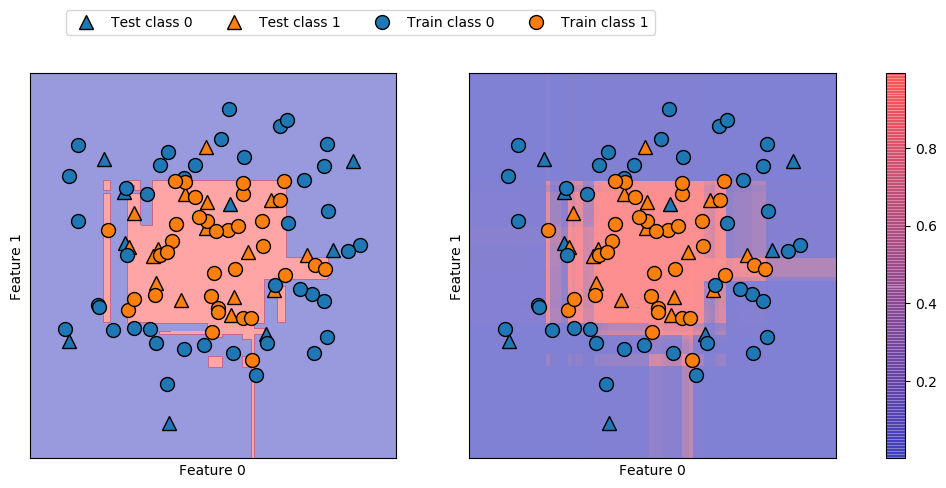

In [25]:
# 決定境界(左)と予測確立(右)の可視化
fig, axes = plt.subplots(1,2,figsize=(13,5))
mglearn.tools.plot_2d_separator(gbrt, X, ax=axes[0], alpha=.4, fill=True, cm=mglearn.cm2)
score_image = mglearn.tools.plot_2d_scores(gbrt, X, ax=axes[1], alpha=.4, cm=mglearn.ReBl, function='predict_proba')

for ax in axes:
    # 訓練データポイントとテストデータポイントをプロット
    mglearn.discrete_scatter(X_test[:, 0], X_test[:, 1], y_test, markers='^', ax=ax)
    mglearn.discrete_scatter(X_train[:, 0], X_train[:, 1], y_train, markers='o', ax=ax)
    ax.set_xlabel('Feature 0')
    ax.set_ylabel('Feature 1')
cbar = plt.colorbar(score_image, ax=axes.tolist())
axes[0].legend(['Test class 0','Test class 1','Train class 0','Train class 1'], ncol=4, loc=(.1,1.1))

この図では境界がはっきりしており、わずかに存在する確信度が低い領域もはっきりわかる。

詳細は[Classifier comparison](https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html)を見るとよい。様々なモデルによる不確実性推定の結果が比較されている。


## 2.4.3 多クラス分類の不確実性
多クラス分類に対しても決定関数, 確率の予測は成り立つ

In [26]:
from sklearn.datasets import load_iris
iris = load_iris()
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, random_state=0)

gbrt = GradientBoostingClassifier(learning_rate=0.01, random_state=0)
gbrt.fit(X_train, y_train)

# モデルが信じている度合いが格納されており、正であれば「陽性」,負であれば「陰性」を意味する。
print('Decision function shape:{}'.format(gbrt.decision_function(X_test).shape))

# decition-functionの最初のいくつかを表示
# 決定関数の符号だけ見れば、予測クラスがわかる。
print('Decision function:{}'.format(gbrt.decision_function(X_test)[:6]))

Decision function shape:(38, 3)
Decision function:[[-0.50692424 -0.53347791  1.53022838]
 [-0.51151707  1.50574741 -0.48234855]
 [ 1.51897822 -0.53079866 -0.48146442]
 [-0.50756256 -0.53347791  1.53022838]
 [ 1.51897822 -0.53079866 -0.48146442]
 [-0.50985911 -0.53347791  1.53022838]]


In [27]:
# 確信度スコアが最大になるクラスを選ぶことで予測クラスが得られる。
print('Argmax of decision function:\n{}'.format(np.argmax(gbrt.decision_function(X_test), axis=1)))
print('Predictions:\n{}'.format(gbrt.predict(X_test)))

Argmax of decision function:
[2 1 0 2 0 2 0 1 1 1 2 1 1 1 1 0 1 1 0 0 2 1 0 0 2 0 0 1 1 0 2 1 0 2 2 1 0
 2]
Predictions:
[2 1 0 2 0 2 0 1 1 1 2 1 1 1 1 0 1 1 0 0 2 1 0 0 2 0 0 1 1 0 2 1 0 2 2 1 0
 2]


In [28]:
# predict_probaの結果の最初の数行を表示
print('Predicted probabilities:\n{}'.format(gbrt.predict_proba(X_test)[:6]))
# 各行の和がゼロになることを確認
print('Sums:{}'.format(gbrt.predict_proba(X_test)[:6].sum(axis=1)))

Predicted probabilities:
[[0.10370714 0.10098957 0.79530329]
 [0.10474133 0.7874172  0.10784147]
 [0.79111482 0.10186682 0.10701837]
 [0.10364782 0.10099625 0.79535593]
 [0.79111482 0.10186682 0.10701837]
 [0.10343465 0.10102027 0.79554508]]
Sums:[1. 1. 1. 1. 1. 1.]


In [29]:
print('Argmax of predicted probabilities:\n{}'.format(np.argmax(gbrt.predict_proba(X_test), axis=1)))
print('Predictions:\n{}'.format(gbrt.predict(X_test)))

Argmax of predicted probabilities:
[2 1 0 2 0 2 0 1 1 1 2 1 1 1 1 0 1 1 0 0 2 1 0 0 2 0 0 1 1 0 2 1 0 2 2 1 0
 2]
Predictions:
[2 1 0 2 0 2 0 1 1 1 2 1 1 1 1 0 1 1 0 0 2 1 0 0 2 0 0 1 1 0 2 1 0 2 2 1 0
 2]


In [32]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()
# irisデータセットのクラス名で表示する
named_target = iris.target_names[y_train]
logreg.fit(X_train, named_target)
# 訓練データ中のクラス
print('unique classes om training data : {}'.format(logreg.classes_))
# 予測値
print('predictions:{}'.format(logreg.predict(X_test)[:10]))
argmax_dec_func = np.argmax(logreg.decision_function(X_test), axis=1)
# 決定関数のargmax
print('argmax of decision function:{}'.format(argmax_dec_func[:10]))
# 決定関数のargmaxをクラス名にしたもの
print('argmax combined with classes_:{}'.format(logreg.classes_[argmax_dec_func][:10]))

unique classes om training data : ['setosa' 'versicolor' 'virginica']
predictions:['virginica' 'versicolor' 'setosa' 'virginica' 'setosa' 'virginica'
 'setosa' 'versicolor' 'versicolor' 'versicolor']
argmax of decision function:[2 1 0 2 0 2 0 1 1 1]
argmax combined with classes_:['virginica' 'versicolor' 'setosa' 'virginica' 'setosa' 'virginica'
 'setosa' 'versicolor' 'versicolor' 'versicolor']
/home/gpuadmin/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/gpuadmin/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
